# STACKED LEARNERS

---

## PHASE 1: dataset prepration - feature extraction (resnet18) - simple classifiers

In [41]:
import os
import torch
import joblib
import itertools
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
from torch import nn
from torchvision.models import resnet18, ResNet18_Weights
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [3]:
from google.colab import files
uploaded = files.upload()

Saving resnet18-f37072fd.pth to resnet18-f37072fd.pth


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dataset_path = '/content/drive/MyDrive/dataset3'

In [5]:
def load_dataset(dataset_path, test_size=0.2, batch_size=32, random_state=42):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
    dataset_size = len(full_dataset)
    indices = list(range(dataset_size))
    class_names = full_dataset.classes

    train_indices, test_indices = train_test_split(indices, test_size=test_size, random_state=random_state, stratify=[full_dataset.imgs[i][1] for i in indices])

    train_dataset = Subset(full_dataset, train_indices)
    test_dataset = Subset(full_dataset, test_indices)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, class_names

In [7]:
def get_resnet_stages(weights_path=None):
    if weights_path is None:
        model = resnet18(weights=ResNet18_Weights.DEFAULT)
    else:
        model = resnet18()
        state_dict = torch.load(weights_path, weights_only=True)
        model.load_state_dict(state_dict)

    model.eval()

    stages = {
        "initial": nn.Sequential(
            model.conv1,
            model.bn1,
            model.relu
        ),
        "mid": nn.Sequential(
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool,
            model.layer1,
            model.layer2
        ),
        "high": nn.Sequential(
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool,
            model.layer1,
            model.layer2,
            model.layer3,
            model.layer4,
            model.avgpool
        )
    }
    return stages

In [9]:
def extract_features(model_stage, dataloader):

    print(f"Using device: {device}")

    model_stage = model_stage.to(device)
    features = []
    labels = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)

            output = model_stage(images)
            output = output.view(output.size(0), -1)

            features.append(output.cpu())
            labels.append(targets)

    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)

    return features.numpy(), labels.numpy()

In [11]:
dataset_path = "dataset"
train, test, class_names = load_dataset(dataset_path, 0.2, 32, 42)
class_names

['cats', 'dogs', 'horses']

In [13]:
stages = get_resnet_stages("resnet18-f37072fd.pth")

In [15]:
initial_features, initial_labels = extract_features(stages['initial'], train)
initial_features_test, initial_labels_test = extract_features(stages['initial'], test)
print(initial_features.shape)

Using device: cuda
Using device: cuda
(484, 802816)


In [16]:
mid_features, mid_labels = extract_features(stages['mid'], train)
mid_features_test, mid_labels_test = extract_features(stages['mid'], test)
print(mid_features.shape)

Using device: cuda
Using device: cuda
(484, 100352)


In [17]:
high_features, high_labels = extract_features(stages['high'], train)
high_features_test, high_labels_test = extract_features(stages['high'], test)
print(high_features.shape)

Using device: cuda
Using device: cuda
(484, 512)


In [71]:
def compare_feature_visualizations(features, labels, class_names):
    methods = {
        'PCA': PCA(n_components=2),
        't-SNE': TSNE(n_components=2, random_state=42, perplexity=30)
    }

    reduced = {}
    for name, reducer in methods.items():
        reduced[name] = reducer.fit_transform(features)

    # Create side-by-side subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    for ax, (method_name, data) in zip(axes, reduced.items()):
        for class_idx in np.unique(labels):
            idxs = np.where(labels == class_idx)
            ax.scatter(data[idxs, 0], data[idxs, 1],
                       label=class_names[class_idx], alpha=0.7)
        ax.set_title(f"{method_name} Projection")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

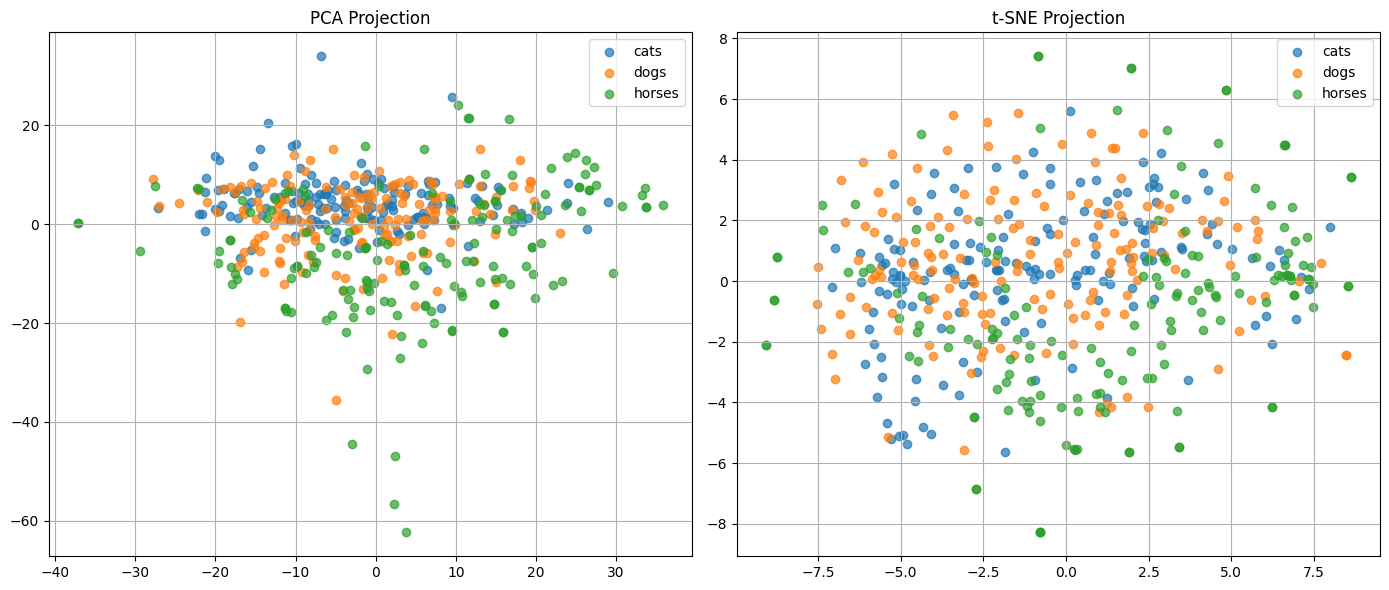

In [73]:
compare_feature_visualizations(initial_features, initial_labels, class_names)

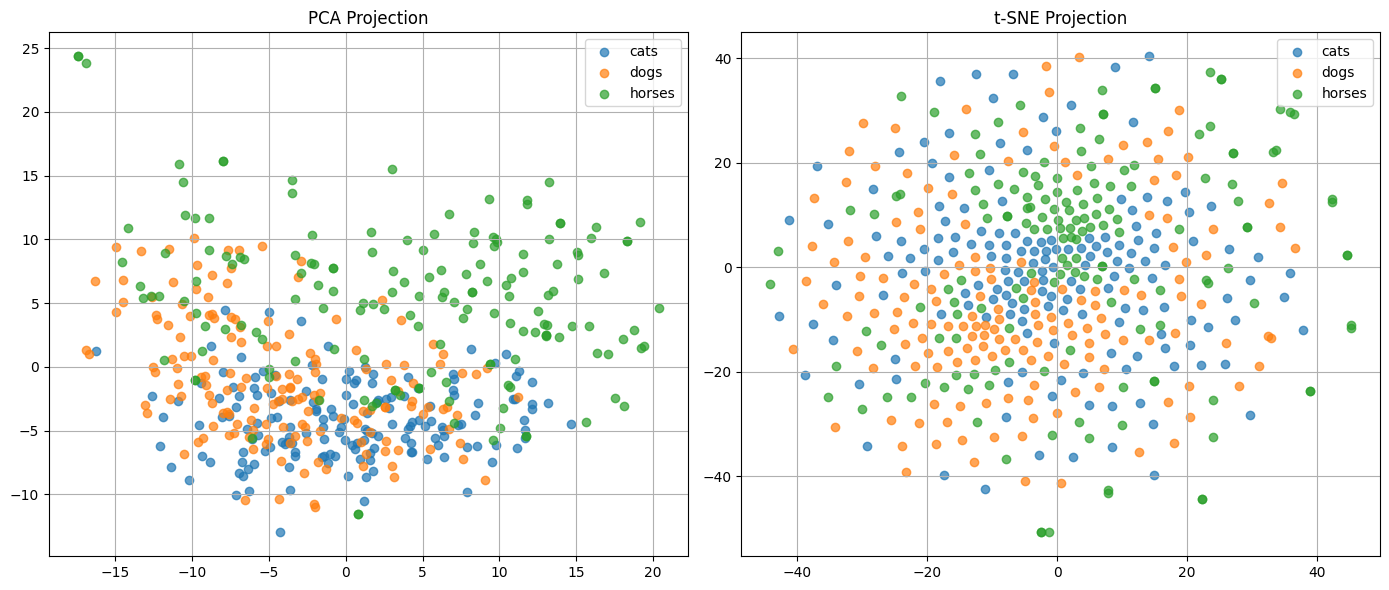

In [45]:
compare_feature_visualizations(mid_features, mid_labels, class_names)

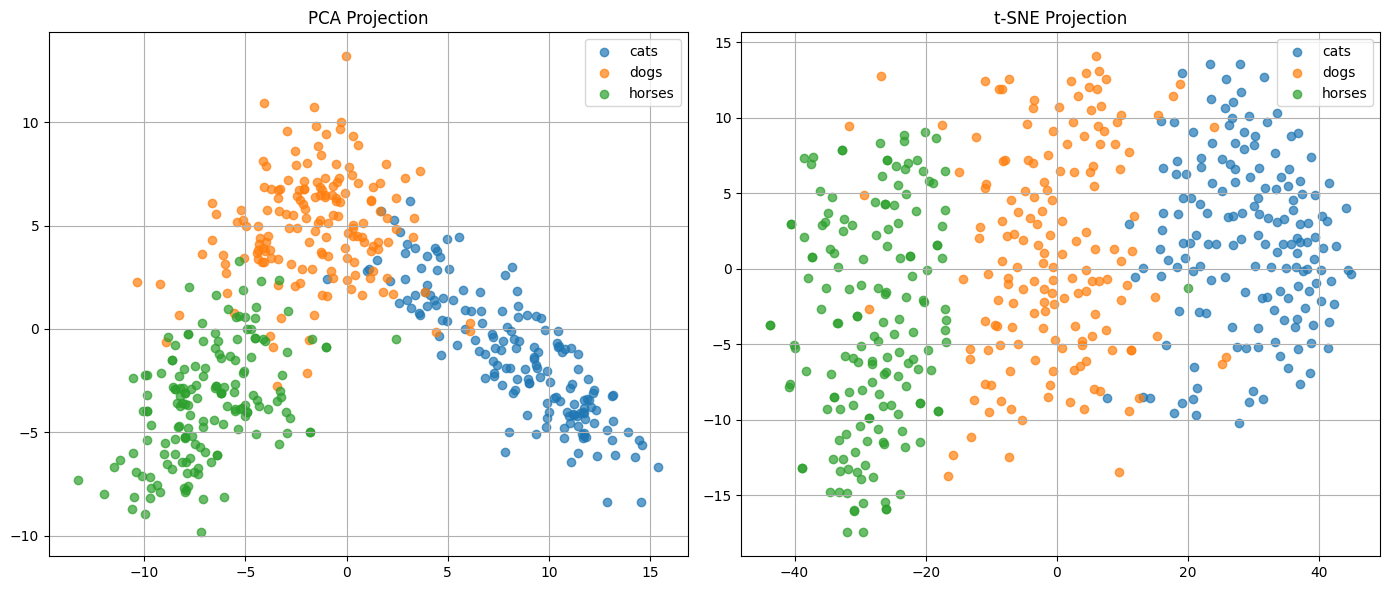

In [47]:
compare_feature_visualizations(high_features, high_labels, class_names)

In [57]:
def plot_confusion_matrices(trained_classifiers, X_test, y_test, class_names):
    """
    Plot confusion matrices for all classifiers in a single row
    """
    n_classifiers = len(trained_classifiers)
    
    fig, axes = plt.subplots(1, n_classifiers, figsize=(5 * n_classifiers, 4))
    
    if n_classifiers == 1:
        axes = [axes]
    
    for idx, (name, clf) in enumerate(trained_classifiers.items()):
        y_pred = clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=class_names, yticklabels=class_names,
                   ax=axes[idx])
        axes[idx].set_title(f'{name}\nConfusion Matrix')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')
        
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].tick_params(axis='y', rotation=0)
    
    plt.tight_layout()
    plt.show()

In [91]:
def plot_classifier_metrics(results_df):
    """
    Plot classifier performance metrics for all classifiers
    """
    metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
    classifiers = results_df["Classifier"]
    n_classifiers = len(classifiers)
    
    # Create dynamic subplot layout
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    for i, metric in enumerate(metrics):
        axes[i].bar(classifiers, results_df[metric], color='skyblue')
        axes[i].set_title(metric)
        axes[i].set_ylim(0, 1)
        axes[i].set_ylabel("Score")
        axes[i].set_xticks(range(len(classifiers)))
        axes[i].set_xticklabels(classifiers, rotation=45)
        axes[i].grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.suptitle("Classifier Comparison Metrics", fontsize=16, y=1.05)
    plt.show()

In [51]:
def train_and_evaluate_classifiers(X_train, y_train, X_test, y_test, class_names):
    classifiers = {
        "SVM": SVC(),
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(),
        "KNN": KNeighborsClassifier(),
        "Decision Tree": DecisionTreeClassifier()
    }
    
    results = []
    trained_classifiers = {}
    
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        accuracy = accuracy_score(y_test, y_pred)
        
        results.append({
            "Classifier": name,
            "Accuracy": round(accuracy, 3),
            "Precision": round(report["weighted avg"]["precision"], 3),
            "Recall": round(report["weighted avg"]["recall"], 3),
            "F1-Score": round(report["weighted avg"]["f1-score"], 3)
        })
        
        trained_classifiers[name] = clf
    
    df = pd.DataFrame(results)
    return df, trained_classifiers

In [75]:
results_df_high, trained_classifiers_high = train_and_evaluate_classifiers(high_features, high_labels, high_features_test, high_labels_test, class_names)
results_df_high

,Classifier,Accuracy,Precision,Recall,F1-Score
0,SVM,0.943,0.944,0.943,0.943
1,Logistic Regression,0.967,0.967,0.967,0.967
2,Random Forest,0.951,0.951,0.951,0.951
3,KNN,0.943,0.945,0.943,0.942
4,Decision Tree,0.820,0.825,0.820,0.821


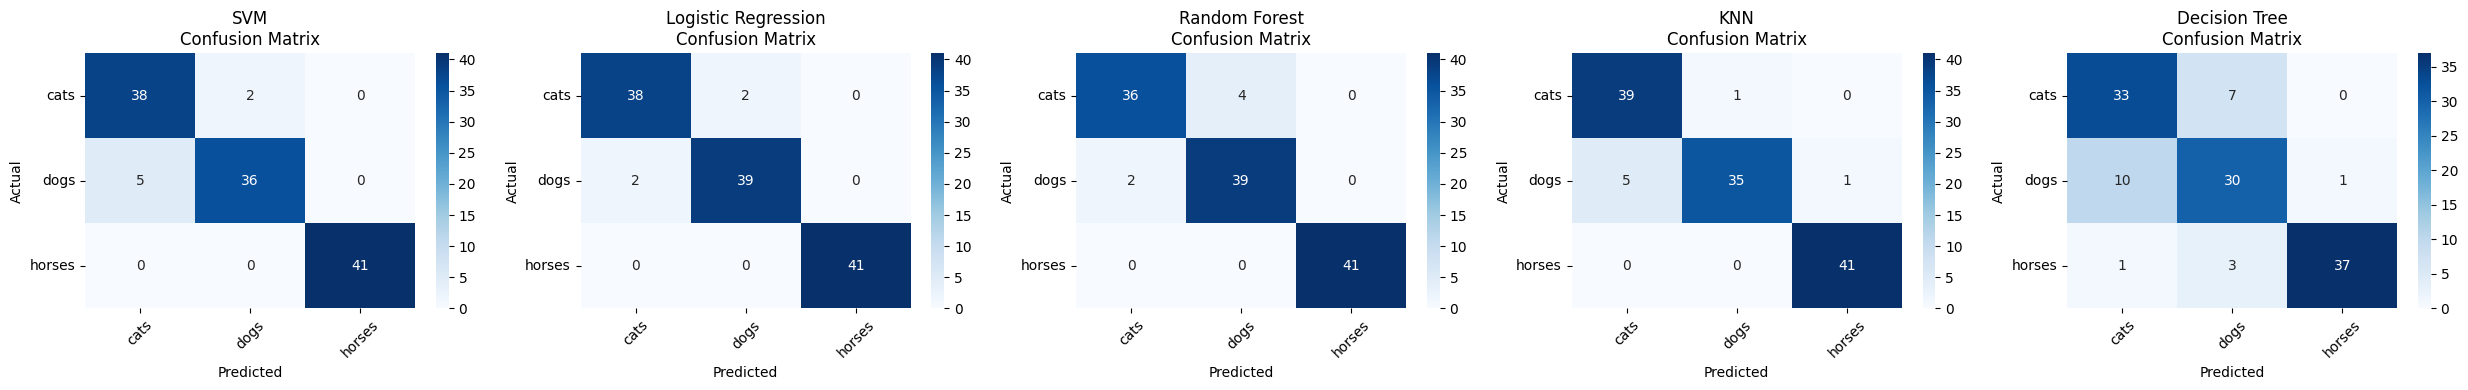

In [77]:
plot_confusion_matrices(trained_classifiers_high, high_features_test, high_labels_test, class_names)

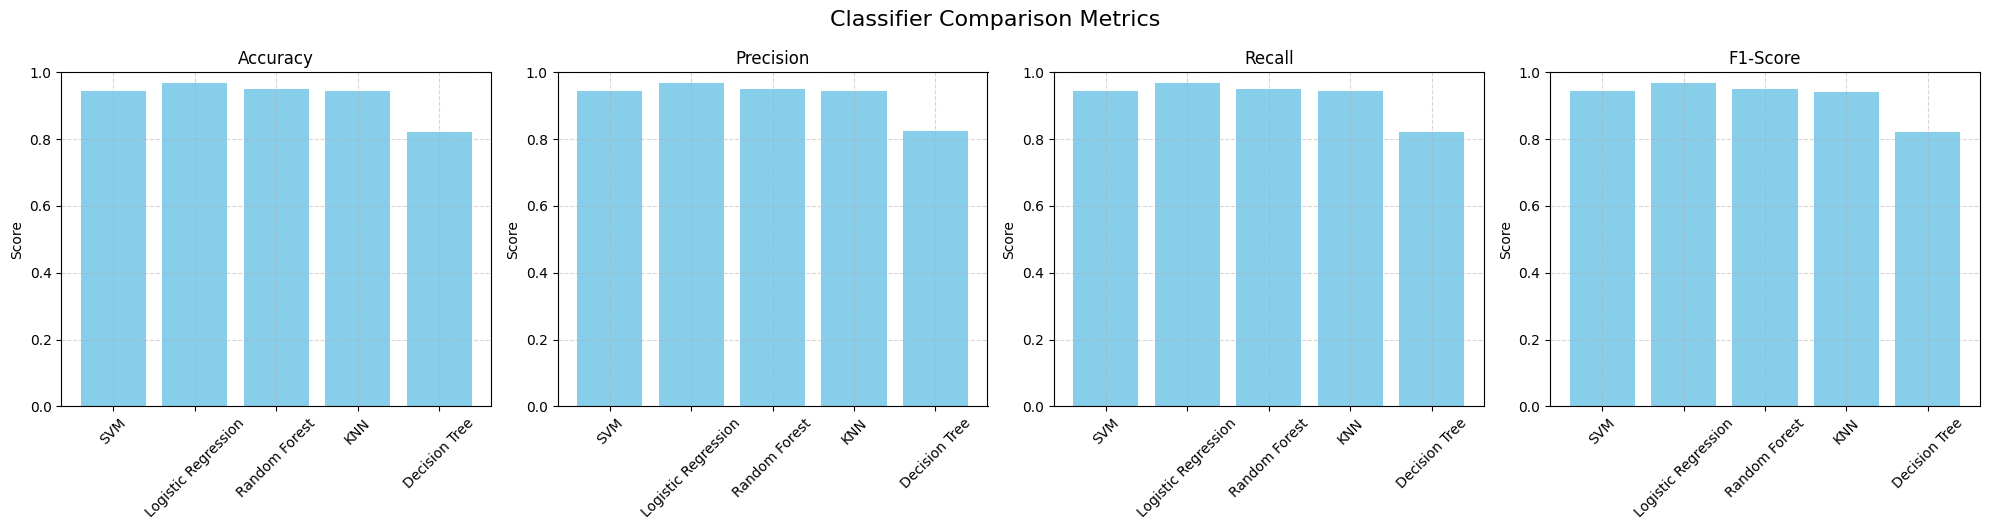

In [95]:
plot_classifier_metrics(results_df_high)

In [85]:
results_df_mid, trained_classifiers_mid = train_and_evaluate_classifiers(mid_features, mid_labels, mid_features_test, mid_labels_test, class_names)
results_df_mid

,Classifier,Accuracy,Precision,Recall,F1-Score
0,SVM,0.770,0.778,0.770,0.773
1,Logistic Regression,0.803,0.806,0.803,0.800
2,Random Forest,0.607,0.615,0.607,0.610
3,KNN,0.451,0.478,0.451,0.454
4,Decision Tree,0.533,0.530,0.533,0.531


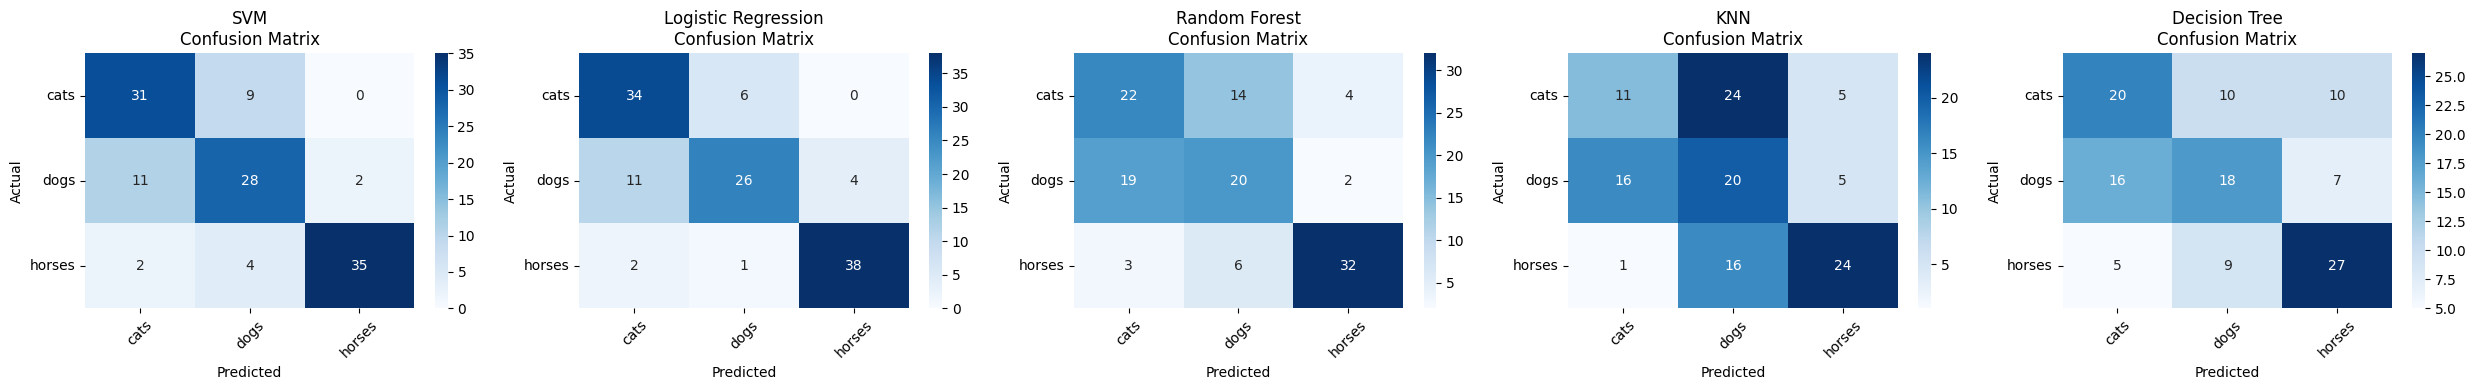

In [99]:
plot_confusion_matrices(trained_classifiers_mid, mid_features_test, mid_labels_test, class_names)

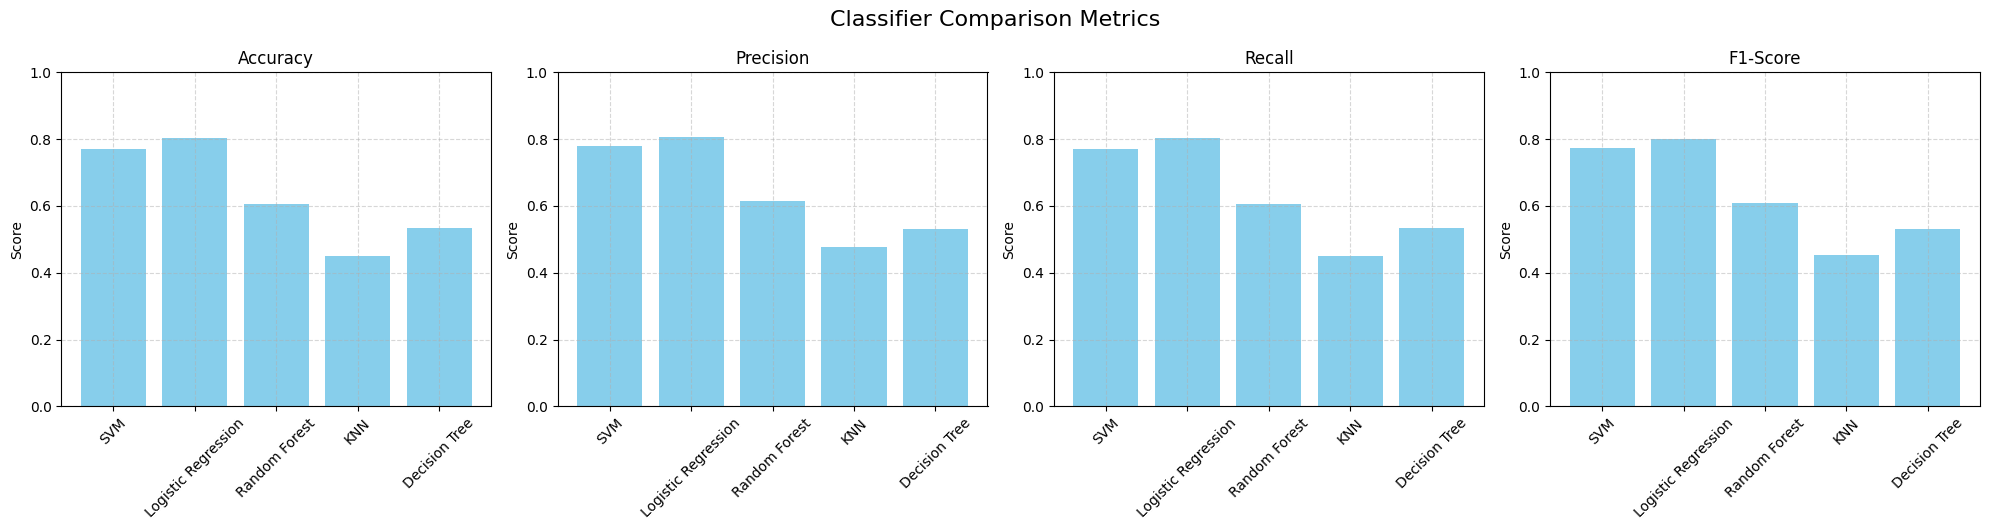

In [97]:
plot_classifier_metrics(results_df_mid)

In [101]:
results_df_initial, trained_classifiers_initial = train_and_evaluate_classifiers(
    initial_features, initial_labels, initial_features_test, initial_labels_test, class_names
)
results_df_initial

,Classifier,Accuracy,Precision,Recall,F1-Score
0,SVM,0.607,0.597,0.607,0.597
1,Logistic Regression,0.656,0.652,0.656,0.636
2,Random Forest,0.672,0.673,0.672,0.660
3,KNN,0.500,0.588,0.500,0.434
4,Decision Tree,0.492,0.485,0.492,0.484


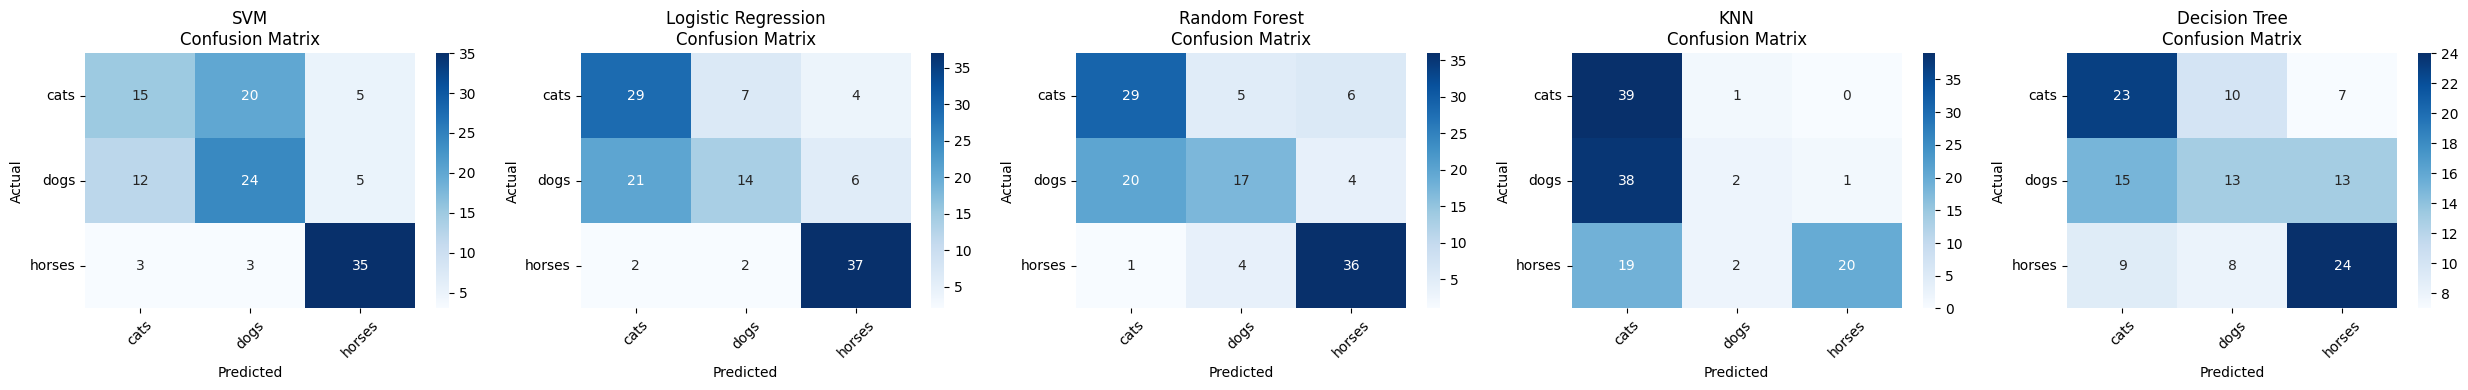

In [103]:
plot_confusion_matrices(trained_classifiers_initial, initial_features_test, initial_labels_test, class_names)

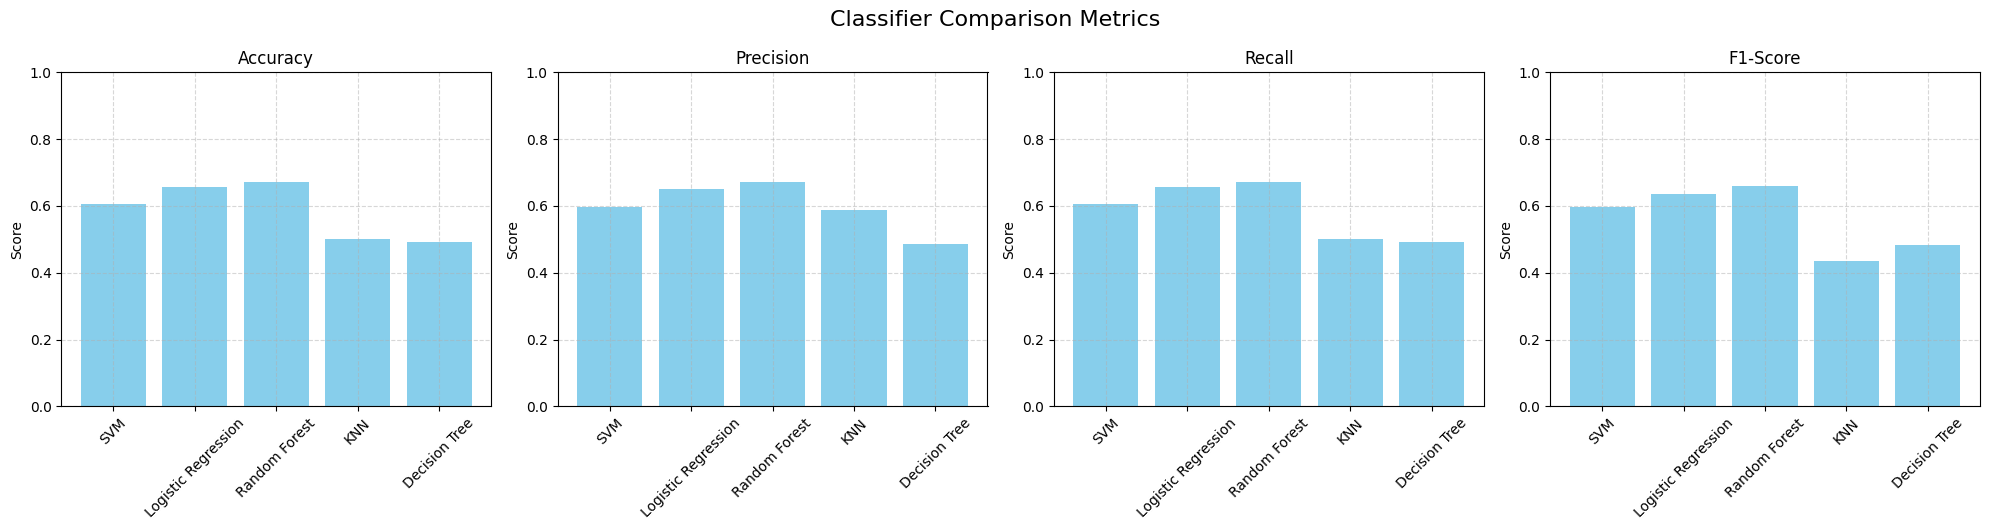

In [104]:
plot_classifier_metrics(results_df_initial)

---

## PHASE 2: stacked learners

In [6]:
def right_way_stacking(X_train, y_train, X_test, y_test, n_splits=5):
    base_models = {
        "SVM": SVC(probability=True, random_state=42),
        "DecisionTree": DecisionTreeClassifier(random_state=42),
        "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
        "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
    }

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    meta_train = np.zeros((X_train.shape[0], sum([len(np.unique(y_train))] * len(base_models))))
    meta_test = np.zeros((X_test.shape[0], sum([len(np.unique(y_train))] * len(base_models))))

    for idx, (name, model) in enumerate(base_models.items()):
        temp_test = np.zeros((X_test.shape[0], len(np.unique(y_train)), n_splits))
        meta_col_start = idx * len(np.unique(y_train))
        meta_col_end = meta_col_start + len(np.unique(y_train))

        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
            X_tr, X_val = X_train[train_idx], X_train[val_idx]
            y_tr, y_val = y_train[train_idx], y_train[val_idx]

            model.fit(X_tr, y_tr)

            meta_train[val_idx, meta_col_start:meta_col_end] = model.predict_proba(X_val)
            temp_test[:, :, fold_idx] = model.predict_proba(X_test)

        meta_test[:, meta_col_start:meta_col_end] = np.mean(temp_test, axis=2)

    meta_model = LogisticRegression(max_iter=1000, random_state=42)
    meta_model.fit(meta_train, y_train)

    y_pred = meta_model.predict(meta_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Stacked Model Accuracy (Right Way): {acc:.4f}")
    return meta_model, y_pred ,meta_test , meta_train

In [85]:
def evaluate_model_performance(meta_model, X_test_meta, y_test, class_labels=None, title="Confusion Matrix"):
    y_pred = meta_model.predict(X_test_meta)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(title)
    plt.show()

<h1>initial features

In [ ]:


scaler = StandardScaler()
X_train = scaler.fit_transform(initial_features)
X_test = scaler.transform(initial_features_test)
y_train = initial_labels
y_test = initial_labels_test

base_models = {
    "SVM": SVC(probability=True, random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}

train_meta = []
test_meta = []

for name, model in base_models.items():
    model.fit(X_train, y_train)
    train_pred = model.predict_proba(X_train)
    test_pred = model.predict_proba(X_test)
    train_meta.append(train_pred)
    test_meta.append(test_pred)

X_train_meta = np.concatenate(train_meta, axis=1)
X_test_meta = np.concatenate(test_meta, axis=1)

meta_model = LogisticRegression(max_iter=1000, random_state=42)
meta_model.fit(X_train_meta, y_train)

y_pred = meta_model.predict(X_test_meta)
acc = accuracy_score(y_test, y_pred)
print(f"Stacked Model Accuracy (Initial Features): {acc:.4f}")

Using device: cuda
Stacked Model Accuracy (Initial Features): 0.6311


In [ ]:
joblib.dump(meta_model, 'meta_model_initial.pkl')

['meta_model_initial.pkl']

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       162
           1       1.00      1.00      1.00       161
           2       1.00      1.00      1.00       161

    accuracy                           1.00       484
   macro avg       1.00      1.00      1.00       484
weighted avg       1.00      1.00      1.00       484



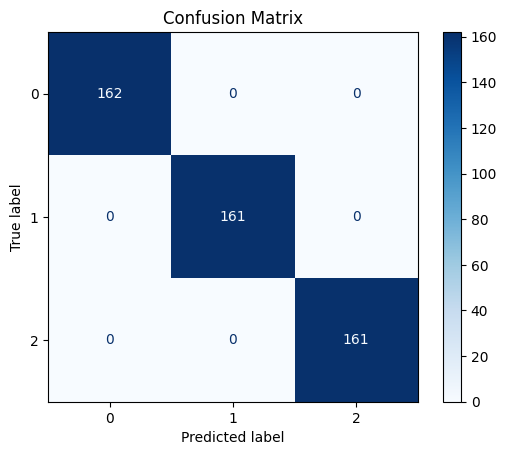

In [ ]:
evaluate_model_performance(meta_model, X_train_meta, y_train, class_labels=None, title="Confusion Matrix")

Accuracy: 0.6311
Precision: 0.6315
Recall: 0.6311
F1 Score: 0.6094

Classification Report:

              precision    recall  f1-score   support

           0       0.54      0.70      0.61        40
           1       0.62      0.32      0.42        41
           2       0.73      0.88      0.80        41

    accuracy                           0.63       122
   macro avg       0.63      0.63      0.61       122
weighted avg       0.63      0.63      0.61       122



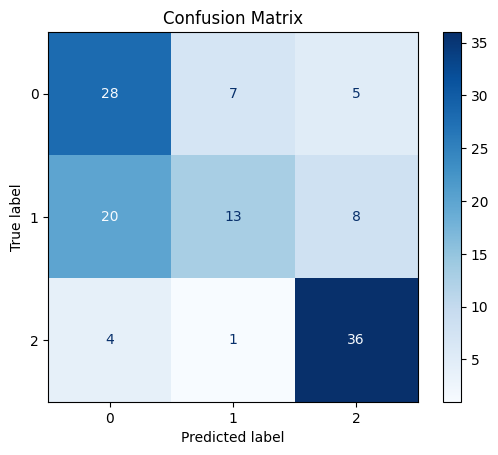

In [ ]:
evaluate_model_performance(meta_model, X_test_meta, y_test, class_labels=None, title="Confusion Matrix")

### mid features

In [ ]:
print(mid_features.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(mid_features)
X_test = scaler.transform(mid_features_test)
y_train = mid_labels
y_test = mid_labels_test

base_models = {
    "SVM": SVC(probability=True, random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}

train_meta = []
test_meta = []

for name, model in base_models.items():
    model.fit(X_train, y_train)
    train_pred = model.predict_proba(X_train)
    test_pred = model.predict_proba(X_test)
    train_meta.append(train_pred)
    test_meta.append(test_pred)

X_train_meta = np.concatenate(train_meta, axis=1)
X_test_meta = np.concatenate(test_meta, axis=1)

meta_model = LogisticRegression(max_iter=1000, random_state=42)
meta_model.fit(X_train_meta, y_train)

y_pred = meta_model.predict(X_test_meta)
acc = accuracy_score(y_test, y_pred)
print(f"Stacked Model Accuracy (Mid Features): {acc:.4f}")

Using device: cuda
(484, 100352)
Using device: cuda
Stacked Model Accuracy (Mid Features): 0.7951


In [ ]:
joblib.dump(meta_model, 'meta_model_mid.pkl')

['meta_model_mid.pkl']

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       162
           1       1.00      1.00      1.00       161
           2       1.00      1.00      1.00       161

    accuracy                           1.00       484
   macro avg       1.00      1.00      1.00       484
weighted avg       1.00      1.00      1.00       484



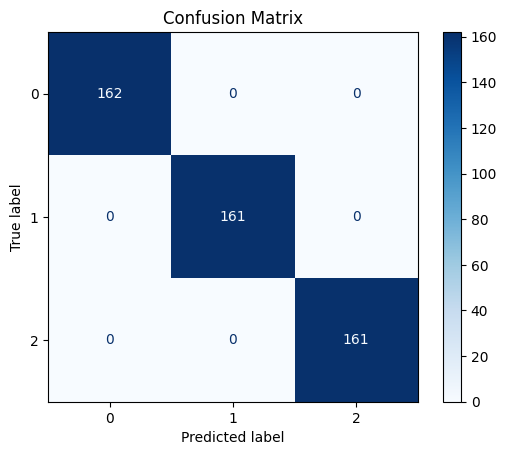

In [ ]:
evaluate_model_performance(meta_model, X_train_meta, y_train, class_labels=None, title="Confusion Matrix")

Accuracy: 0.7951
Precision: 0.7975
Recall: 0.7951
F1 Score: 0.7925

Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.85      0.78        40
           1       0.76      0.63      0.69        41
           2       0.90      0.90      0.90        41

    accuracy                           0.80       122
   macro avg       0.80      0.80      0.79       122
weighted avg       0.80      0.80      0.79       122



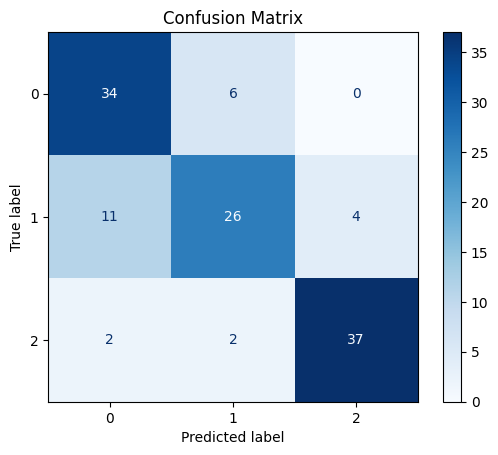

In [ ]:
evaluate_model_performance(meta_model, X_test_meta, y_test, class_labels=None, title="Confusion Matrix")

### high features

In [ ]:
print(high_features.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(high_features)
X_test = scaler.transform(high_features_test)
y_train = high_labels
y_test = high_labels_test

base_models = {
    "SVM": SVC(probability=True, random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}

train_meta = []
test_meta = []

for name, model in base_models.items():
    model.fit(X_train, y_train)
    train_pred = model.predict_proba(X_train)
    test_pred = model.predict_proba(X_test)
    train_meta.append(train_pred)
    test_meta.append(test_pred)

X_train_meta = np.concatenate(train_meta, axis=1)
X_test_meta = np.concatenate(test_meta, axis=1)

meta_model = LogisticRegression(max_iter=1000, random_state=42)
meta_model.fit(X_train_meta, y_train)

y_pred = meta_model.predict(X_test_meta)
acc = accuracy_score(y_test, y_pred)
print(f"Stacked Model Accuracy (Mid Features): {acc:.4f}")

Using device: cuda
(484, 512)
Using device: cuda
Stacked Model Accuracy (Mid Features): 0.9508


In [ ]:
joblib.dump(meta_model, 'meta_model_high.pkl')

['meta_model_high.pkl']

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       162
           1       1.00      1.00      1.00       161
           2       1.00      1.00      1.00       161

    accuracy                           1.00       484
   macro avg       1.00      1.00      1.00       484
weighted avg       1.00      1.00      1.00       484



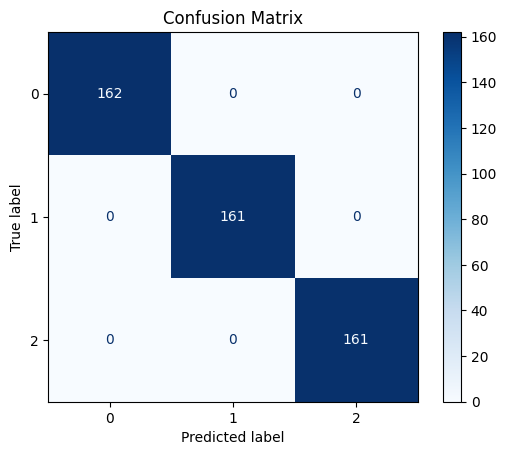

In [ ]:
evaluate_model_performance(meta_model, X_train_meta, y_train, class_labels=None, title="Confusion Matrix")

Accuracy: 0.9508
Precision: 0.9508
Recall: 0.9508
F1 Score: 0.9508

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        40
           1       0.93      0.93      0.93        41
           2       1.00      1.00      1.00        41

    accuracy                           0.95       122
   macro avg       0.95      0.95      0.95       122
weighted avg       0.95      0.95      0.95       122



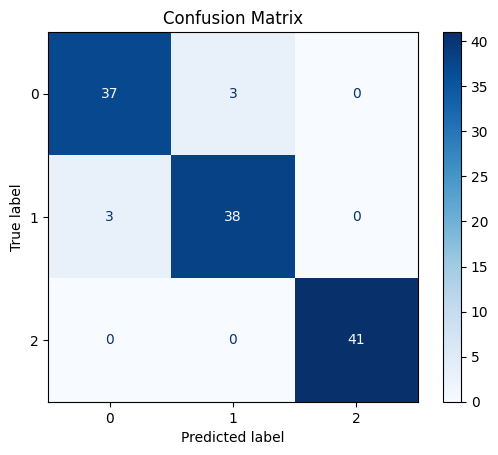

In [ ]:
evaluate_model_performance(meta_model, X_test_meta, y_test, class_labels=None, title="Confusion Matrix")

### high features with overfit preventing

In [ ]:
print(high_features.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(high_features)
X_test = scaler.transform(high_features_test)
y_train = high_labels
y_test = high_labels_test
scaler = StandardScaler()
X_train = scaler.fit_transform(high_features)
X_test = scaler.transform(high_features_test)

meta_model, y_pred ,X_test_meta , X_train_meta  = right_way_stacking(X_train, high_labels, X_test, high_labels_test)


Using device: cuda
(484, 512)
Using device: cuda
Stacked Model Accuracy (Right Way): 0.9672


In [ ]:
joblib.dump(meta_model, 'meta_model_high_OP.pkl')

['meta_model_high_OP.pkl']

Accuracy: 0.9669
Precision: 0.9671
Recall: 0.9669
F1 Score: 0.9670

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       162
           1       0.95      0.96      0.95       161
           2       0.99      0.99      0.99       161

    accuracy                           0.97       484
   macro avg       0.97      0.97      0.97       484
weighted avg       0.97      0.97      0.97       484



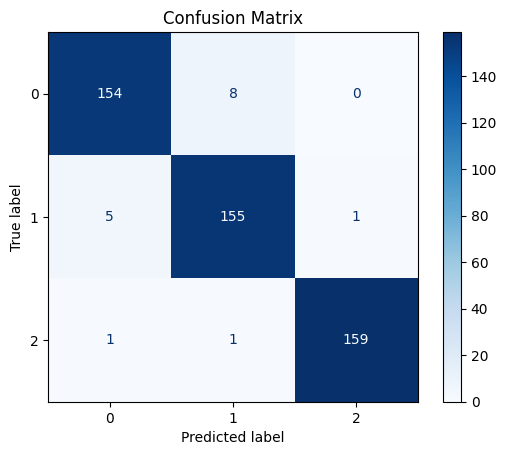

In [ ]:
evaluate_model_performance(meta_model, X_train_meta, y_train, class_labels=None, title="Confusion Matrix")

Accuracy: 0.9672
Precision: 0.9679
Recall: 0.9672
F1 Score: 0.9672

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.93      0.95        40
           1       0.93      0.98      0.95        41
           2       1.00      1.00      1.00        41

    accuracy                           0.97       122
   macro avg       0.97      0.97      0.97       122
weighted avg       0.97      0.97      0.97       122



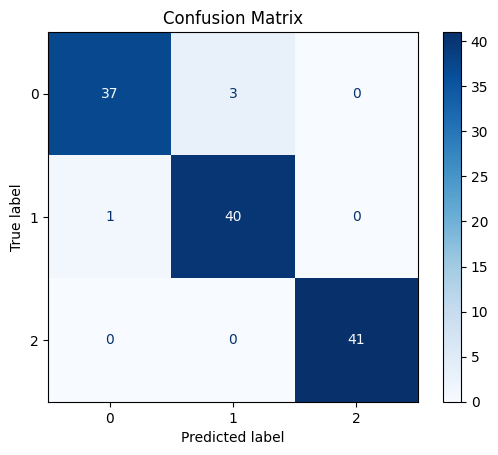

In [ ]:
evaluate_model_performance(meta_model, X_test_meta, y_test, class_labels=None, title="Confusion Matrix")

### mid features with overfit preventing

In [ ]:
print(mid_features.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(mid_features)
X_test = scaler.transform(mid_features_test)
y_train = mid_labels
y_test = mid_labels_test
scaler = StandardScaler()
X_train = scaler.fit_transform(mid_features)
X_test = scaler.transform(mid_features_test)

meta_model, y_pred ,X_test_meta , X_train_meta = right_way_stacking(X_train, mid_labels, X_test, mid_labels_test)


Using device: cuda
(484, 100352)
Using device: cuda
Stacked Model Accuracy (Right Way): 0.7787


In [ ]:
joblib.dump(meta_model, 'meta_model_mid_OP.pkl')

['meta_model_mid_OP.pkl']

Accuracy: 0.7686
Precision: 0.7720
Recall: 0.7686
F1 Score: 0.7694

Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.78      0.75       162
           1       0.68      0.65      0.67       161
           2       0.92      0.87      0.89       161

    accuracy                           0.77       484
   macro avg       0.77      0.77      0.77       484
weighted avg       0.77      0.77      0.77       484



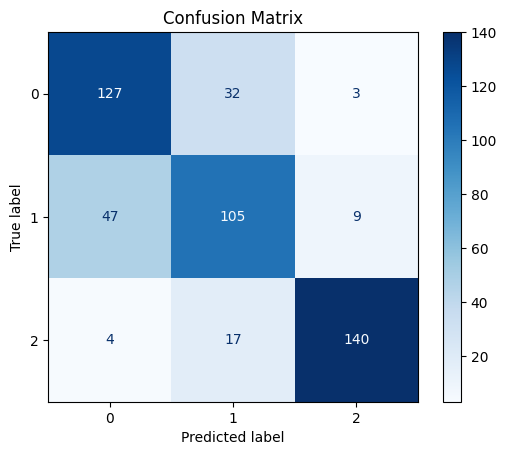

In [ ]:
evaluate_model_performance(meta_model, X_train_meta, y_train, class_labels=None, title="Confusion Matrix")

Accuracy: 0.7787
Precision: 0.7818
Recall: 0.7787
F1 Score: 0.7797

Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.78      0.75        40
           1       0.70      0.68      0.69        41
           2       0.92      0.88      0.90        41

    accuracy                           0.78       122
   macro avg       0.78      0.78      0.78       122
weighted avg       0.78      0.78      0.78       122



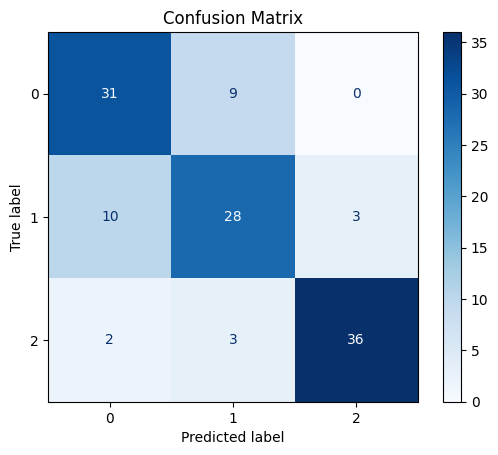

In [ ]:
evaluate_model_performance(meta_model, X_test_meta, y_test, class_labels=None, title="Confusion Matrix")

### initial features with overfit preventing

In [11]:
print(initial_features.shape)

scaler = StandardScaler()
X_train = scaler.fit_transform(initial_features)
X_test = scaler.transform(initial_features_test)
y_train = initial_labels
y_test = initial_labels_test
scaler = StandardScaler()
X_train = scaler.fit_transform(initial_features)
X_test = scaler.transform(initial_features_test)

meta_model, y_pred ,X_test_meta , X_train_meta = right_way_stacking(X_train, initial_labels, X_test, initial_labels_test,2)


Using device: cuda
(484, 802816)
Using device: cuda
Stacked Model Accuracy (Right Way): 0.6475


In [12]:
joblib.dump(meta_model, 'meta_model_initial_OP.pkl')

['meta_model_initial_OP.pkl']

Accuracy: 0.6033
Precision: 0.5988
Recall: 0.6033
F1 Score: 0.6004

Classification Report:

              precision    recall  f1-score   support

           0       0.59      0.62      0.60       162
           1       0.49      0.44      0.46       161
           2       0.72      0.75      0.73       161

    accuracy                           0.60       484
   macro avg       0.60      0.60      0.60       484
weighted avg       0.60      0.60      0.60       484



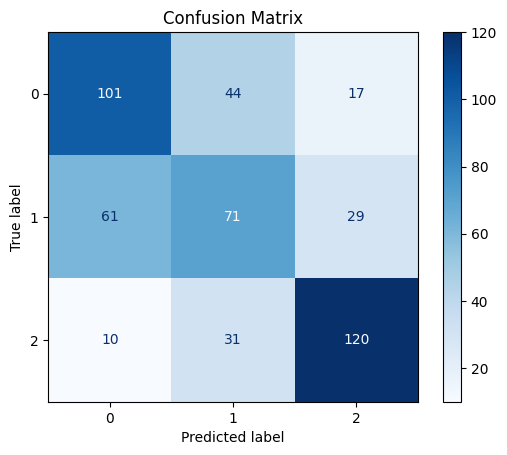

In [13]:
evaluate_model_performance(meta_model, X_train_meta, y_train, class_labels=None, title="Confusion Matrix")

Accuracy: 0.6475
Precision: 0.6385
Recall: 0.6475
F1 Score: 0.6334

Classification Report:

              precision    recall  f1-score   support

           0       0.58      0.62      0.60        40
           1       0.61      0.41      0.49        41
           2       0.73      0.90      0.80        41

    accuracy                           0.65       122
   macro avg       0.64      0.65      0.63       122
weighted avg       0.64      0.65      0.63       122



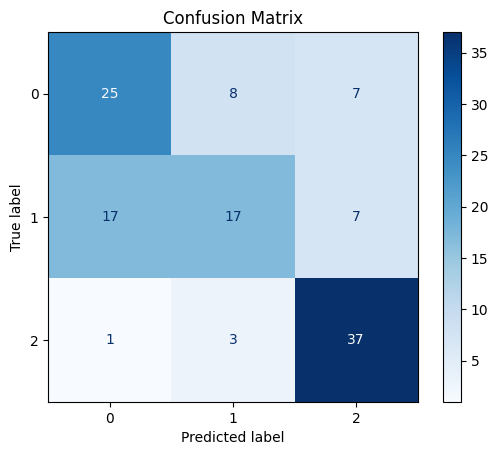

In [14]:
evaluate_model_performance(meta_model, X_test_meta, y_test, class_labels=None, title="Confusion Matrix")

## hyperparameter tuning - no overfit prevention

In [145]:
def evaluate_model_performance(
    meta_model,
    X_test_meta,
    y_test,
    X_train_meta=None,
    y_train=None,
    class_labels=None,
    title_test="Confusion Matrix (Test)",
    title_train="Confusion Matrix (Train)"
):
    def get_metrics(y_true, y_pred):
        return {
            "Accuracy": accuracy_score(y_true, y_pred),
            "Precision": precision_score(y_true, y_pred, average='weighted'),
            "Recall": recall_score(y_true, y_pred, average='weighted'),
            "F1 Score": f1_score(y_true, y_pred, average='weighted'),
        }

    results_summary = []

    # ==== Test set ====
    y_pred_test = meta_model.predict(X_test_meta)
    test_metrics = get_metrics(y_test, y_pred_test)
    results_summary.append(("Test", test_metrics))
    cm_test = confusion_matrix(y_test, y_pred_test)

    # ==== Train set (optional) ====
    y_pred_train = None
    cm_train = None
    train_metrics = None
    if X_train_meta is not None and y_train is not None:
        y_pred_train = meta_model.predict(X_train_meta)
        train_metrics = get_metrics(y_train, y_pred_train)
        results_summary.append(("Train", train_metrics))
        cm_train = confusion_matrix(y_train, y_pred_train)

    # ==== Confusion matrices side by side ====
    num_plots = 1 + int(cm_train is not None)
    fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 4))

    if num_plots == 1:
        axes = [axes]

    # Test matrix
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=class_labels)
    disp_test.plot(ax=axes[0], cmap='Blues', values_format='d', colorbar=False)
    axes[0].set_title(title_test)

    # Train matrix
    if cm_train is not None:
        disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=class_labels)
        disp_train.plot(ax=axes[1], cmap='Greens', values_format='d', colorbar=False)
        axes[1].set_title(title_train)

    plt.tight_layout()
    plt.show()

    # ==== Print reports ====
    if y_pred_train is not None:
        print("\n[Train Set Classification Report]")
        print(classification_report(y_train, y_pred_train))

    print("\n[Test Set Classification Report]")
    print(classification_report(y_test, y_pred_test))

    # ==== Print metrics summary ====
    print("\n[Summary Metrics]")
    for label, metrics in results_summary:
        print(f"{label} Set:")
        for key, value in metrics.items():
            print(f"  {key}: {value:.4f}")
        print()

    return {
        "train_pred": y_pred_train,
        "test_pred": y_pred_test,
        "confusion_matrices": {
            "train": cm_train,
            "test": cm_test
        },
        "metrics": dict(results_summary)
    }


In [35]:
configurations = {
    "SVM": {
        "C": [0.1, 1.0],
        "kernel": ["rbf", "linear"]
    },
    "DecisionTree": {
        "max_depth": [3, 5],
        "min_samples_split": [2, 4]
    },
    "LogisticRegression": {
        "C": [0.1, 1.0],
        "penalty": ["l2"]
    },
    "RandomForest": {
        "n_estimators": [50, 100],
        "max_depth": [4, 6]
    }
}

In [37]:
def generate_all_stack_configs(config_dict):
    all_configs = []

    keys = list(config_dict.keys())

    model_param_combos = {}

    for model_name, params in config_dict.items():

        param_names = list(params.keys())
        param_values = list(params.values())
        all_param_combinations = list(itertools.product(*param_values)) 

        combos = []
        for values in all_param_combinations:
            param_dict = dict(zip(param_names, values))
            combos.append(param_dict)

        model_param_combos[model_name] = combos

    for svm_cfg in model_param_combos["SVM"]:
        for dt_cfg in model_param_combos["DecisionTree"]:
            for lr_cfg in model_param_combos["LogisticRegression"]:
                for rf_cfg in model_param_combos["RandomForest"]:
                    all_configs.append({
                        "SVM": svm_cfg,
                        "DecisionTree": dt_cfg,
                        "LogisticRegression": lr_cfg,
                        "RandomForest": rf_cfg
                    })

    return all_configs

In [39]:
all_configs = generate_all_stack_configs(configurations)
print(f"Total configurations generated: {len(all_configs)}")

Total configurations generated: 128


In [151]:
def train_and_evaluate_stack(config, X_train, y_train, X_test, y_test):
    base_models = {
        "SVM": SVC(**config["SVM"], probability=True, random_state=42),
        "DecisionTree": DecisionTreeClassifier(**config["DecisionTree"], random_state=42),
        "LogisticRegression": LogisticRegression(**config["LogisticRegression"], max_iter=1000, random_state=42),
        "RandomForest": RandomForestClassifier(**config["RandomForest"], random_state=42)
    }

    train_meta = []
    test_meta = []

    for name, model in base_models.items():
        model.fit(X_train, y_train)
        train_pred = model.predict_proba(X_train)
        test_pred = model.predict_proba(X_test)
        train_meta.append(train_pred)
        test_meta.append(test_pred)

    X_train_meta = np.concatenate(train_meta, axis=1)
    X_test_meta = np.concatenate(test_meta, axis=1)

    meta_model = LogisticRegression(max_iter=1000, random_state=42)
    meta_model.fit(X_train_meta, y_train)
    y_pred = meta_model.predict(X_test_meta)
    acc = accuracy_score(y_test, y_pred)

    return meta_model, acc, X_train_meta, X_test_meta

In [165]:
def run_stacked_trials(all_configs, features, labels, features_test, labels_test,
                       num_trials=100, top_k=5, verbose=True):
    """
    Runs multiple stacked model configurations and returns the top performing ones.
    
    Returns a list of dicts: {"model": ..., "config": ..., "acc": ...}
    """
    scaler = StandardScaler()
    X_train = scaler.fit_transform(features)
    X_test = scaler.transform(features_test)
    y_train = labels
    y_test = labels_test

    sampled_configs = random.sample(all_configs, num_trials)
    results = []

    for i, config in enumerate(sampled_configs):
        if verbose:
            # print(f"\n[Trial {i+1}/{num_trials}]")
            pass
        model, acc, X_train_meta, X_test_meta = train_and_evaluate_stack(config, X_train, y_train, X_test, y_test)
        results.append({
            "model": model,
            "config": config,
            "acc": acc,
            "meta_train": X_train_meta,
            "meta_test": X_test_meta
        })

    top_results = sorted(results, key=lambda x: x["acc"], reverse=True)[:top_k]

    if verbose:
        print(f"Top {top_k} Configurations:")
        for i, entry in enumerate(top_results, 1):
            print(f"\n--- Top {i} ---")
            print(f"Accuracy: {entry['acc']:.4f}")
            for model_name, model_config in entry["config"].items():
                print(f"  {model_name}: {model_config}")

    return top_results

In [167]:
top_high_configs = run_stacked_trials(
    all_configs=all_configs,
    features=high_features,
    labels=high_labels,
    features_test=high_features_test,
    labels_test=high_labels_test,
    num_trials=30,
    top_k=5
)

Top 5 Configurations:

--- Top 1 ---
Accuracy: 0.9754
  SVM: {'C': 0.1, 'kernel': 'rbf'}
  DecisionTree: {'max_depth': 5, 'min_samples_split': 4}
  LogisticRegression: {'C': 0.1, 'penalty': 'l2'}
  RandomForest: {'n_estimators': 50, 'max_depth': 6}

--- Top 2 ---
Accuracy: 0.9754
  SVM: {'C': 0.1, 'kernel': 'rbf'}
  DecisionTree: {'max_depth': 3, 'min_samples_split': 2}
  LogisticRegression: {'C': 1.0, 'penalty': 'l2'}
  RandomForest: {'n_estimators': 50, 'max_depth': 6}

--- Top 3 ---
Accuracy: 0.9672
  SVM: {'C': 0.1, 'kernel': 'rbf'}
  DecisionTree: {'max_depth': 5, 'min_samples_split': 2}
  LogisticRegression: {'C': 0.1, 'penalty': 'l2'}
  RandomForest: {'n_estimators': 100, 'max_depth': 4}

--- Top 4 ---
Accuracy: 0.9672
  SVM: {'C': 0.1, 'kernel': 'rbf'}
  DecisionTree: {'max_depth': 5, 'min_samples_split': 4}
  LogisticRegression: {'C': 1.0, 'penalty': 'l2'}
  RandomForest: {'n_estimators': 100, 'max_depth': 4}

--- Top 5 ---
Accuracy: 0.9672
  SVM: {'C': 0.1, 'kernel': 'rbf'}
 

In [185]:
best_entry_high = top_high_configs[0]
best_model_high = best_entry_high["model"]
best_config_high = best_entry_high["config"]
best_accuracy_high = best_entry_high["acc"]
meta_train_high = best_entry_high["meta_train"]
meta_test_high = best_entry_high["meta_test"]

print(f"Best Accuracy: {best_accuracy_high:.4f}")
print("Best Configuration:")
for model_name, params in best_config_high.items():
    print(f"  {model_name}: {params}")

joblib.dump(best_model_high, "saved_models/best_model_high.pkl")

Best Accuracy: 0.9754
Best Configuration:
  SVM: {'C': 0.1, 'kernel': 'rbf'}
  DecisionTree: {'max_depth': 5, 'min_samples_split': 4}
  LogisticRegression: {'C': 0.1, 'penalty': 'l2'}
  RandomForest: {'n_estimators': 50, 'max_depth': 6}


['saved_models/best_model_high.pkl']

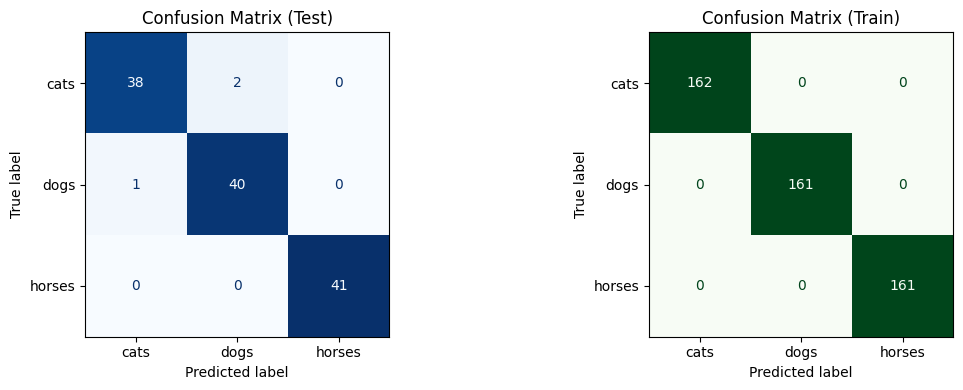


[Train Set Classification Report]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       162
           1       1.00      1.00      1.00       161
           2       1.00      1.00      1.00       161

    accuracy                           1.00       484
   macro avg       1.00      1.00      1.00       484
weighted avg       1.00      1.00      1.00       484


[Test Set Classification Report]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        40
           1       0.95      0.98      0.96        41
           2       1.00      1.00      1.00        41

    accuracy                           0.98       122
   macro avg       0.98      0.98      0.98       122
weighted avg       0.98      0.98      0.98       122


[Summary Metrics]
Test Set:
  Accuracy: 0.9754
  Precision: 0.9756
  Recall: 0.9754
  F1 Score: 0.9754

Train Set:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.00

In [175]:
results = evaluate_model_performance(
    meta_model=best_model_high,
    X_test_meta=meta_test_high,
    y_test=high_labels_test,
    X_train_meta=meta_train_high,
    y_train=high_labels,
    class_labels=class_names
)

In [177]:
top_mid_configs = run_stacked_trials(
    all_configs=all_configs,
    features=mid_features,
    labels=mid_labels,
    features_test=mid_features_test,
    labels_test=mid_labels_test,
    num_trials=10,
    top_k=5
)

Top 5 Configurations:

--- Top 1 ---
Accuracy: 0.8279
  SVM: {'C': 1.0, 'kernel': 'linear'}
  DecisionTree: {'max_depth': 5, 'min_samples_split': 4}
  LogisticRegression: {'C': 1.0, 'penalty': 'l2'}
  RandomForest: {'n_estimators': 50, 'max_depth': 6}

--- Top 2 ---
Accuracy: 0.8197
  SVM: {'C': 0.1, 'kernel': 'rbf'}
  DecisionTree: {'max_depth': 5, 'min_samples_split': 4}
  LogisticRegression: {'C': 1.0, 'penalty': 'l2'}
  RandomForest: {'n_estimators': 100, 'max_depth': 6}

--- Top 3 ---
Accuracy: 0.8115
  SVM: {'C': 0.1, 'kernel': 'rbf'}
  DecisionTree: {'max_depth': 5, 'min_samples_split': 2}
  LogisticRegression: {'C': 0.1, 'penalty': 'l2'}
  RandomForest: {'n_estimators': 50, 'max_depth': 6}

--- Top 4 ---
Accuracy: 0.8115
  SVM: {'C': 0.1, 'kernel': 'rbf'}
  DecisionTree: {'max_depth': 3, 'min_samples_split': 4}
  LogisticRegression: {'C': 1.0, 'penalty': 'l2'}
  RandomForest: {'n_estimators': 100, 'max_depth': 6}

--- Top 5 ---
Accuracy: 0.8115
  SVM: {'C': 0.1, 'kernel': 'rbf'

In [183]:
best_entry_mid = top_mid_configs[0]
best_model_mid = best_entry_mid["model"]
best_config_mid = best_entry_mid["config"]
best_accuracy_mid = best_entry_mid["acc"]
meta_train_mid = best_entry_mid["meta_train"]
meta_test_mid = best_entry_mid["meta_test"]

print(f"Best Accuracy: {best_accuracy_mid:.4f}")
print("Best Configuration:")
for model_name, params in best_config_mid.items():
    print(f"  {model_name}: {params}")

joblib.dump(best_model_mid, "saved_models/best_meta_model_mid.pkl")

Best Accuracy: 0.8279
Best Configuration:
  SVM: {'C': 1.0, 'kernel': 'linear'}
  DecisionTree: {'max_depth': 5, 'min_samples_split': 4}
  LogisticRegression: {'C': 1.0, 'penalty': 'l2'}
  RandomForest: {'n_estimators': 50, 'max_depth': 6}


['saved_models/best_meta_model_mid.pkl']

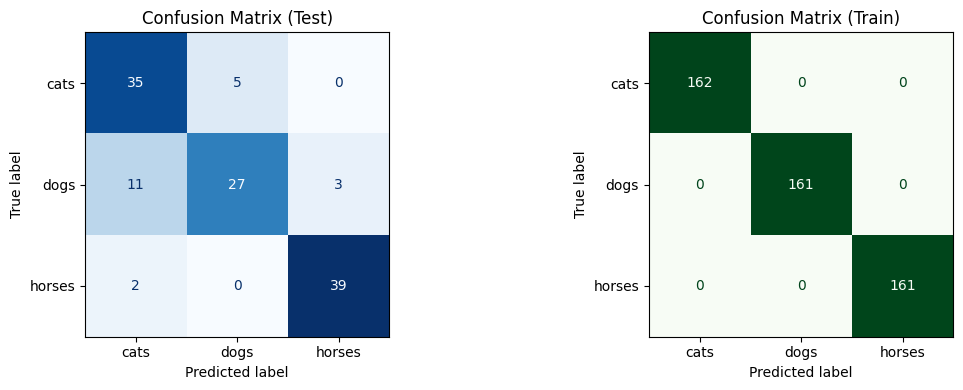


[Train Set Classification Report]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       162
           1       1.00      1.00      1.00       161
           2       1.00      1.00      1.00       161

    accuracy                           1.00       484
   macro avg       1.00      1.00      1.00       484
weighted avg       1.00      1.00      1.00       484


[Test Set Classification Report]
              precision    recall  f1-score   support

           0       0.73      0.88      0.80        40
           1       0.84      0.66      0.74        41
           2       0.93      0.95      0.94        41

    accuracy                           0.83       122
   macro avg       0.83      0.83      0.82       122
weighted avg       0.83      0.83      0.83       122


[Summary Metrics]
Test Set:
  Accuracy: 0.8279
  Precision: 0.8347
  Recall: 0.8279
  F1 Score: 0.8252

Train Set:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.00

In [181]:
results_mid = evaluate_model_performance(
    meta_model=best_model_mid,
    X_test_meta=meta_test_mid,
    y_test=mid_labels_test,
    X_train_meta=meta_train_mid,
    y_train=mid_labels,
    class_labels=class_names
)

## hyperparameter tuning - with overfit prevention

In [75]:
def right_way_stacking(X_train, y_train, X_test, y_test, config, n_splits=5):
    base_models = {
        "SVM": SVC(**config["SVM"], probability=True, random_state=42),
        "DecisionTree": DecisionTreeClassifier(**config["DecisionTree"], random_state=42),
        "LogisticRegression": LogisticRegression(**config["LogisticRegression"], max_iter=1000, random_state=42),
        "RandomForest": RandomForestClassifier(**config["RandomForest"], random_state=42)
    }

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    num_classes = len(np.unique(y_train))
    meta_train = np.zeros((X_train.shape[0], num_classes * len(base_models)))
    meta_test = np.zeros((X_test.shape[0], num_classes * len(base_models)))

    for idx, (name, model) in enumerate(base_models.items()):
        temp_test = np.zeros((X_test.shape[0], num_classes, n_splits))
        col_start = idx * num_classes
        col_end = col_start + num_classes

        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
            X_tr, X_val = X_train[train_idx], X_train[val_idx]
            y_tr, y_val = y_train[train_idx], y_train[val_idx]

            model.fit(X_tr, y_tr)
            meta_train[val_idx, col_start:col_end] = model.predict_proba(X_val)
            temp_test[:, :, fold_idx] = model.predict_proba(X_test)

        meta_test[:, col_start:col_end] = np.mean(temp_test, axis=2)

    meta_model = LogisticRegression(max_iter=1000, random_state=42)
    meta_model.fit(meta_train, y_train)
    y_pred = meta_model.predict(meta_test)
    acc = accuracy_score(y_test, y_pred)

    return meta_model, acc, meta_train, meta_test, y_pred


In [79]:
def run_cv_stacked_trials(all_configs, features, labels, features_test, labels_test,
                          num_trials=30, top_k=5, verbose=True, n_splits=5):
    """
    Runs stacking with cross-validation on multiple configs and returns top results.
    """
    scaler = StandardScaler()
    X_train = scaler.fit_transform(features)
    X_test = scaler.transform(features_test)
    y_train = labels
    y_test = labels_test

    sampled_configs = random.sample(all_configs, num_trials)
    results = []

    for i, config in enumerate(sampled_configs):
        if verbose:
            # print(f"\n[Trial {i+1}/{num_trials}]")
            pass
        try:
            meta_model, acc, meta_train, meta_test, y_pred = right_way_stacking(
                X_train, y_train, X_test, y_test,
                config=config, n_splits=n_splits
            )
            results.append({
                "model": meta_model,
                "config": config,
                "acc": acc,
                "meta_train": meta_train,
                "meta_test": meta_test,
                "y_pred": y_pred
            })
        except Exception as e:
            print(f"[ERROR] Skipping config due to error: {e}")

    top_results = sorted(results, key=lambda x: x["acc"], reverse=True)[:top_k]

    if verbose:
        print(f"Top {top_k} Configurations with Cross-Validated Stacking:")
        for i, entry in enumerate(top_results, 1):
            print(f"\n--- Top {i} ---")
            print(f"Accuracy: {entry['acc']:.4f}")
            for model_name, model_config in entry["config"].items():
                print(f"  {model_name}: {model_config}")

    return top_results


In [81]:
top_high_cv_configs = run_cv_stacked_trials(
    all_configs=all_configs,
    features=high_features,
    labels=high_labels,
    features_test=high_features_test,
    labels_test=high_labels_test,
    num_trials=50,
    top_k=5,
    verbose=True
)

Top 5 Configurations with Cross-Validated Stacking:

--- Top 1 ---
Accuracy: 0.9754
  SVM: {'C': 0.1, 'kernel': 'linear'}
  DecisionTree: {'max_depth': 3, 'min_samples_split': 2}
  LogisticRegression: {'C': 1.0, 'penalty': 'l2'}
  RandomForest: {'n_estimators': 100, 'max_depth': 6}

--- Top 2 ---
Accuracy: 0.9754
  SVM: {'C': 1.0, 'kernel': 'linear'}
  DecisionTree: {'max_depth': 3, 'min_samples_split': 2}
  LogisticRegression: {'C': 1.0, 'penalty': 'l2'}
  RandomForest: {'n_estimators': 100, 'max_depth': 4}

--- Top 3 ---
Accuracy: 0.9754
  SVM: {'C': 0.1, 'kernel': 'linear'}
  DecisionTree: {'max_depth': 3, 'min_samples_split': 4}
  LogisticRegression: {'C': 0.1, 'penalty': 'l2'}
  RandomForest: {'n_estimators': 50, 'max_depth': 6}

--- Top 4 ---
Accuracy: 0.9754
  SVM: {'C': 0.1, 'kernel': 'linear'}
  DecisionTree: {'max_depth': 3, 'min_samples_split': 2}
  LogisticRegression: {'C': 1.0, 'penalty': 'l2'}
  RandomForest: {'n_estimators': 50, 'max_depth': 6}

--- Top 5 ---
Accuracy: 0

In [187]:
best_entry_high_cv = top_high_cv_configs[0]
best_model_high_cv = best_entry_high_cv["model"]
best_config_high_cv = best_entry_high_cv["config"]
best_accuracy_high_cv = best_entry_high_cv["acc"]
meta_train_high_cv = best_entry_high_cv["meta_train"]
meta_test_high_cv = best_entry_high_cv["meta_test"]

print(f"Best Accuracy: {best_accuracy_high_cv:.4f}")
print("Best Configuration:")
for model_name, params in best_config_high_cv.items():
    print(f"  {model_name}: {params}")

joblib.dump(best_model_high_cv, "saved_models/best_model_high_cv.pkl")

Best Accuracy: 0.9754
Best Configuration:
  SVM: {'C': 0.1, 'kernel': 'linear'}
  DecisionTree: {'max_depth': 3, 'min_samples_split': 2}
  LogisticRegression: {'C': 1.0, 'penalty': 'l2'}
  RandomForest: {'n_estimators': 100, 'max_depth': 6}


['saved_models/best_model_high_cv.pkl']

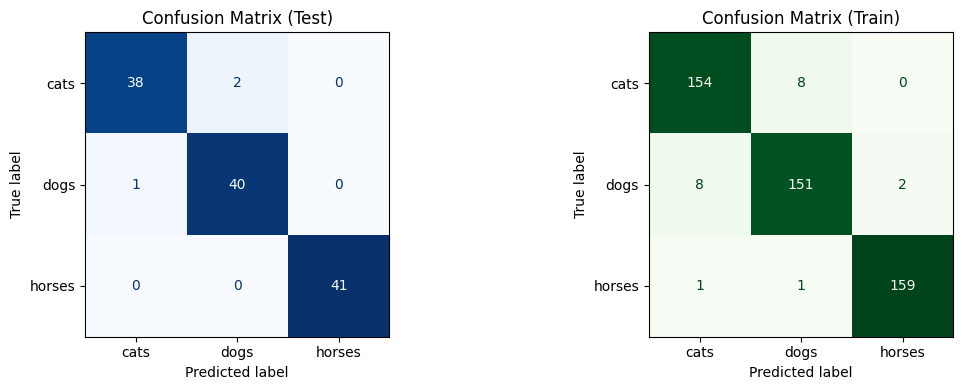


[Train Set Classification Report]
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       162
           1       0.94      0.94      0.94       161
           2       0.99      0.99      0.99       161

    accuracy                           0.96       484
   macro avg       0.96      0.96      0.96       484
weighted avg       0.96      0.96      0.96       484


[Test Set Classification Report]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        40
           1       0.95      0.98      0.96        41
           2       1.00      1.00      1.00        41

    accuracy                           0.98       122
   macro avg       0.98      0.98      0.98       122
weighted avg       0.98      0.98      0.98       122


[Summary Metrics]
Test Set:
  Accuracy: 0.9754
  Precision: 0.9756
  Recall: 0.9754
  F1 Score: 0.9754

Train Set:
  Accuracy: 0.9587
  Precision: 0.9587
  Recall: 0.95

In [143]:
results = evaluate_model_performance(
    meta_model=best_model_high_cv,
    X_test_meta=meta_test_high_cv,
    y_test=high_labels_test,
    X_train_meta=meta_train_high_cv,
    y_train=high_labels,
    class_labels=class_names
)

In [ ]:
top_mid_cv_configs = run_cv_stacked_trials(
    all_configs=all_configs,
    features=mid_features,
    labels=mid_labels,
    features_test=mid_features_test,
    labels_test=mid_labels_test,
    num_trials=10,
    top_k=5,
    verbose=True
)

In [ ]:
best_entry_mid_cv = top_mid_cv_configs[0]
best_model_mid_cv = best_entry_mid_cv["model"]
best_config_mid_cv = best_entry_mid_cv["config"]
best_accuracy_mid_cv = best_entry_mid_cv["acc"]
meta_train_mid_cv = best_entry_mid_cv["meta_train"]
meta_test_mid_cv = best_entry_mid_cv["meta_test"]

print(f"Best Accuracy: {best_accuracy_mid_cv:.4f}")
print("Best Configuration:")
for model_name, params in best_config_mid_cv.items():
    print(f"  {model_name}: {params}")

joblib.dump(best_model_mid_cv, "saved_models/best_model_mid_cv.pkl")

In [ ]:
results_mid_cv = evaluate_model_performance(
    meta_model=best_model_mid_cv,
    X_test_meta=meta_test_mid_cv,
    y_test= mid_labels_test,
    X_train_meta=meta_train_mid_cv,
    y_train=mid_labels,
    class_labels=class_names
)

In [ ]:
top_initial_cv_configs = run_cv_stacked_trials(
    all_configs=all_configs,
    features=initial_features,
    labels=initial_labels,
    features_test=initial_features_test,
    labels_test=initial_labels_test,
    num_trials=10,
    top_k=5,
    verbose=True
)

In [ ]:
best_entry_initial_cv = top_initial_cv_configs[0]
best_model_initial_cv = best_entry_initial_cv["model"]
best_config_initial_cv = best_entry_initial_cv["config"]
best_accuracy_initial_cv = best_entry_initial_cv["acc"]
meta_train_initial_cv = best_entry_initial_cv["meta_train"]
meta_test_initial_cv = best_entry_initial_cv["meta_test"]

print(f"Best Accuracy: {best_accuracy_initial_cv:.4f}")
print("Best Configuration:")
for model_name, params in top_initial_cv_configs.items():
    print(f"  {model_name}: {params}")

joblib.dump(best_model_initial_cv, "saved_models/best_model_initial_cv.pkl")

In [ ]:
results_initial_cv = evaluate_model_performance(
    meta_model=best_model_initial_cv,
    X_test_meta=meta_test_initial_cv,
    y_test= initial_labels_test,
    X_train_meta=meta_train_initial_cv,
    y_train=initial_labels,
    class_labels=class_names
)